In [5]:
from selective_recruitment.plotting import make_scatterplot
from selective_recruitment.scripts.script_mapwise import calc_ttest_mean
from selective_recruitment.scripts.script_roi_differences import norm_within_category # for results after normalization
import selective_recruitment.data as ss
import selective_recruitment.regress as ra
import selective_recruitment.region as sroi

from statsmodels.stats.anova import AnovaRM  # perform F test
from scipy.stats import ttest_rel

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [6]:
# setting working directory
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'

# selective recruitment: ROI-based
scatterplots and statistical tests on the residuals for the selected region of interest

In [7]:
# setting up names and colors
label_dict = {1: 'LfLs', 2: 'LfMs',
              3: 'LfHs', 4: 'MfLs',
              5: 'HfLs', 6:'rest'}
marker_dict = {1: '^', 2: 'X',
               3: 'X', 4: 'o',
               5: 'o', 6: 's'}
color_dict = {1: 'grey', 2: 'r',
              3: 'r', 4: 'b',
              5: 'b', 6: 'g'}

## Prepare the data for the scatterplot and the test

* Pick one parcellation: Here NettekovenSym32, a data-driven hierarchical symmetric parcellation. ROI will be selected from this parcellation.
* ss.get_summary_conn first uses a connectivity model to get predicted values for all the cerebellar voxels and then summarize the predicted values by averaging the values within the selected region of interest.


In [25]:
# get the summary df with observed and predicted activation within cerebellar parcels

## set params
dataset = "WMFS"
ses_id = 'ses-01'
parcellation = "NettekovenSym32"
cortex = "Icosahedron1002"
train_dataset = "Fusion"
train_ses_id = 'all'
method = "L2regression"
type = "CondHalf"
crossed = True
mname_base = f"{train_dataset}_{train_ses_id}_{cortex}_{method}"#f'Fusion_all_{cortex}_L2regression'
mname_ext = "_09" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model
# # get predicted and observed within region of interest
# D = ss.get_summary_conn(dataset = dataset,
#                      ses_id = ses_id,
#                      subj = None, # to do all the subjects
#                      atlas_space = "SUIT3",
#                      cerebellum_roi = parcellation,
#                      cerebellum_roi_selected = None,
#                      cortex_roi = cortex,
#                      type = type,
#                      add_rest = True,
#                      mname_base = mname_base, # Fusion_all_Icosahedron1002_L2Regression_05_avg
#                      mname_ext = mname_ext,
#                      crossed = crossed)

# # apply regression to get residuals
# # this second regression is implemented because direct comparison of observed and 
# # predicted activation is not possible due to different scaling
# D = ra.roi_regress(D, fit_intercept=True)

# # save the df
# D.to_csv(wkdir + f'/fs_ROI_{type}_{train_dataset}_{train_ses_id}_{method}{mname_ext}_reg.tsv', sep='\t')
D = pd.read_csv(wkdir + f'/fs_ROI_{type}_{train_dataset}_{train_ses_id}_{method}{mname_ext}_reg.tsv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit/fs_ROI_CondHalf_Fusion_all_L2regression_09_reg.tsv'

### Select region of interest.
Here we pick one parcel by first focusing on one network, the most relevant network: here the motor network. From the sub-regions within that network, we pick the one that shows consistently high activation throughout the task

In [ ]:
roi_exp = "M.." # roi_exp = "D.?3.?R|D.?3.?L" # roi_exp = "D.?3.?R"
_, _, selected_ = sroi.get_parcel_single(parcellation = parcellation, 
                                               atlas_space = "SUIT3",
                                               roi_exp = roi_exp)
print(selected_)
table = pd.pivot_table(D.loc[np.isin(D.roi_name.values, selected_)], values='Y', index=['roi_name'], aggfunc=np.mean)
sorted_regions = table.sort_values(by=["Y"],ascending=False)
display(sorted_regions.T)
roi_selected = sorted_regions.T.columns[0]
print(f"selected region is {roi_selected}")


### make the scatterplot and test the residuals

/Users/lshahsha/Documents/GitHub/selective_recruitment/plotting.py:87: FutureWarning: The provided callable <function mean at 0x10b8e15e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = grouped.agg(agg_kw)


                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  4.9802 4.0000 60.0000 0.0016



/Users/lshahsha/Documents/GitHub/selective_recruitment/.sr-venv/lib/python3.9/site-packages/statsmodels/stats/anova.py:508: FutureWarning: The provided callable <function mean at 0x10b8e15e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.data = (self.data


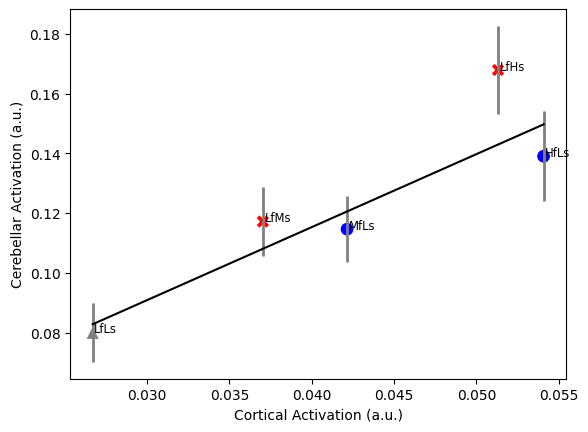

In [9]:
# get the dataframe with the selected region
selected_roi = "M3R"
df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
make_scatterplot(df, split='cond_num',
                labels=label_dict,
                markers=marker_dict,
                colors=color_dict)
# plt.xlabel("predicted cerebellar activation")
plt.savefig(f"fs_{selected_roi}_scatter_{mname_base}_{mname_ext}.pdf")
print(AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())

In [10]:
df.R2.mean()
# calculate standard error per subject
df['se'] = df.groupby(['sn'])['res'].transform('sem')
df.se.mean()

/var/folders/2s/y135h01d68qcfhvrkxjt13780000gp/T/ipykernel_77254/894869824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['se'] = df.groupby(['sn'])['res'].transform('sem')


0.010621086173385624

In [23]:
A = pd.pivot_table(df, values='res', index=['sn'], columns=['cond_name'], aggfunc=np.mean)
# delete the spaces from the end of the condition names
A.columns = A.columns.str.strip()
# AA = np.array(A)
print(ttest_rel(A.LM, A.ML, nan_policy='omit', alternative='greater')) # Medium speed - Medium force
print(ttest_rel(A.LH, A.HL, nan_policy='omit', alternative='greater')) # High speed - High force

TtestResult(statistic=1.944687658571955, pvalue=0.03540393039605075, df=15)
TtestResult(statistic=2.372689543466131, pvalue=0.015728885799323616, df=15)


/var/folders/2s/y135h01d68qcfhvrkxjt13780000gp/T/ipykernel_77254/1323633075.py:1: FutureWarning: The provided callable <function mean at 0x10b8e15e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  A = pd.pivot_table(df, values='res', index=['sn'], columns=['cond_name'], aggfunc=np.mean)
